# EDA for the Ninapro DB 8

In [1]:
import h5py
import os
import scipy.io
from collections import Counter
import matplotlib.pyplot as plt
import logging
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
from scipy import signal
from tqdm import tqdm
from scipy.fft import fft, fftfreq, rfft, rfftfreq

pd.set_option('display.max_rows', 1000)



In [2]:
COLOR_DICT = {'midnight_blue': '#2c3e50', 'pomgrenate': '#c0392b', 'pumpkin': '#d35400', 
              'green_sea': '#16a085',
              'wisteria': '#8e44ad', 'orange': '#f39c12', 'turquoise': '#1abc9c', 'grey': '#7f8c8d',
             'lotus':'#f368e0', 'nasu':'#5f27cd'}


In [3]:
def parse_mat_file_to_dict(filepath):
    data = {}
    f = h5py.File(filepath, 'r')
    for k, v in f.items():
        data[k] = np.array(v)
    return f, data

# Loading Dataset

In [4]:
data_dir = 'data/'
subject = 1
subject_dataset = 1
subject_file = f'S{subject}_E1_A{subject_dataset}.mat'  #S1_E1_A1.mat
mat = scipy.io.loadmat(os.path.join(data_dir,subject_file))

In [5]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Dec 06 15:23:01 2018',
 '__version__': '1.0',
 '__globals__': [],
 'subject': array([[1]], dtype=uint8),
 'exercise': array([[1]], dtype=uint8),
 'emg': array([[-1.2213888e-05,  1.2848358e-05,  1.4171899e-06, ...,
          2.4547974e-06, -3.5635583e-07,  3.9899796e-06],
        [-1.1034591e-05,  1.1959419e-05, -8.0825924e-07, ...,
          7.5772382e-06, -7.6994631e-08,  9.7154589e-06],
        [-5.5595945e-07,  1.0261851e-05, -9.0351966e-07, ...,
          9.7515685e-06, -2.5459797e-06,  6.3704433e-06],
        ...,
        [-3.5108628e-06, -1.2804191e-05,  1.3349400e-06, ...,
         -3.4621539e-07, -2.2962845e-06,  1.2677652e-06],
        [-9.1614737e-07, -1.4396191e-05,  3.9385824e-07, ...,
         -1.8846814e-06, -2.8121669e-06,  1.2581410e-07],
        [ 8.8349225e-08, -1.3151894e-05, -2.0248261e-07, ...,
         -2.3238319e-06, -3.3372892e-06,  1.1472472e-07]], dtype=float32),
 'acc': array([[ 0.967795

# Dataset Description

### Acquisition
For each participant, three datasets were collected: 
- the first two datasets (acquisitions 1 & 2) comprised **10 repetitions of each movement** and the third dataset (acquisition 3) comprised only two repetitions. 
- For each subject, the associated .zip file contains three MATLAB files in .mat format, that is, one for each dataset, with synchronized variables.

The variables included in the .mat files are the following:
- subject: subject number
- exercise: exercise number (value set to 1 in all data files)
- emg (16 columns): sEMG signals from the 16 sensors
- acc (48 columns): three-axis accelerometer data from the 16 sensors
- gyro (48 columns): three-axis gyroscope data from the 16 sensors
- mag (48 columns): three-axis magnetometer data from the 16 sensors
- glove (18 columns): calibrated signals from the 18 sensors of the Cyberglove
- stimulus (1 column): the movement repeated by the subject
- restimulus (1 column): again the movement repeated by the subject. In this case, the duration of the movement label is refined a-posteriori in order to correspond to the real movement.
- repetition (1 column): repetition number of the stimulus
- rerepetition (1 column): repetition number of restimulus


### Sampling frequency and Preprocessing
- The muscular activity was recorded using 16 active double-differential wireless sensors from a Delsys Trigno IM Wireless EMG system. The sensors comprise EMG electrodes and 9-axis inertial measurement units (IMUs). The sensors were positioned in two rows of eight units around the participants’ right forearm in correspondence to the radiohumeral joint (see pictures below). No specific muscles were targeted. The sensors were fixed on the forearm using the standard manufacturer-provided adhesive bands. 
- Moreover, a hypoallergenic elastic latex-free band was placed around the sensors to keep them fixed during the acquisition. 
- Sampling rate:
    - **The sEMG signals were sampled at a rate of 1111 Hz**, 
    - **accelerometer and gyroscope data were sampled at 148 Hz**
    - **magnetometer data were sampled at 74 Hz**. 
    - **All signals were upsampled to 2 kHz and post-synchronized.**
    
### Recorded target (i.e hand movements)
- During the acquisition, the subjects were asked to repeat 9 movements using both hands (bilateral mirrored movements). 
- The duration of each of the nine movements varied between **6 and 9 seconds** and consecutive trials were interleaved with **3 seconds of rest**. 
- Each repetition started with the participant holding their fingers at the rest state and involved slowly reaching the target posture as shown on the screen and returning to the rest state before the end of the trial. 

- The following movements were included:
    0. rest
    1. thumb flexion/extension
    2. thumb abduction/adduction
    3. index finger flexion/extension
    4. middle finger flexion/extension
    5. combined ring and little fingers flexion/extension
    6. index pointer
    7. cylindrical grip
    8. lateral grip
    9. tripod grip



# Dataset Insights

In [6]:
print(f"EMG data:{mat['emg'].shape}\nGlove data:{mat['glove'].shape} \nacc data:{mat['acc'].shape}")
print(f"\nstimulus data:{mat['stimulus'].shape} \nrestimulus data:{mat['restimulus'].shape}")
print(f"\nrepetition data:{mat['repetition'].shape} \nrerepetition data:{mat['rerepetition'].shape}")


print(f"Rerepetition value count:\n{Counter(mat['rerepetition'][:,0])}")
Counter(mat['restimulus'][:,0])

EMG data:(2292526, 16)
Glove data:(2292526, 18) 
acc data:(2292526, 48)

stimulus data:(2292526, 1) 
restimulus data:(2292526, 1)

repetition data:(2292526, 1) 
rerepetition data:(2292526, 1)
Rerepetition value count:
Counter({1: 291411, 6: 235135, 4: 231914, 8: 225229, 10: 224936, 2: 219693, 3: 216540, 5: 215265, 9: 213469, 7: 209056, 0: 9878})


Counter({0: 1188175,
         1: 82564,
         2: 93842,
         3: 160468,
         4: 120850,
         5: 112737,
         6: 88592,
         7: 175325,
         8: 120336,
         9: 149637})

- sEMG has 16 channels.
- 'rerepetition' variable defines the number of trial per movement.
- 'restimulus' defines the target gesture to be performed by subject. This variable takes in a value from 0 to 9 representing the 10 classes of gestures + rest

In [8]:
Counter(mat['stimulus'][:,0])

Counter({0: 796495,
         1: 139161,
         2: 141287,
         3: 168908,
         4: 147710,
         5: 147201,
         6: 147253,
         7: 218899,
         8: 181869,
         9: 203743})

In [9]:
FS = 2000
N_CH = mat['emg'].shape[1]

rec_duration = mat['emg'].shape[0]/FS
rec_time = np.arange(0,rec_duration, 1/FS)
print(f"Total recording duration for this subject {subject}: {rec_duration} seconds")
print(f"Creating time axis: \nbeg {rec_time[:5]} \nend {rec_time[-5:]}\n")
print(f"sEMG Channels: {N_CH}")

Total recording duration for this subject 1: 1146.263 seconds
Creating time axis: 
beg [0.     0.0005 0.001  0.0015 0.002 ] 
end [1146.2605 1146.261  1146.2615 1146.262  1146.2625]

sEMG Channels: 16


In [42]:
# loading into df for easier handling
emg_df = pd.DataFrame(mat['emg'])
emg_df['time'] = rec_time
emg_df['restimulus'] = mat['restimulus']
emg_df['rerepetition'] = mat['rerepetition']
emg_df['trial'] = (emg_df['restimulus'] != emg_df['restimulus'].shift()).cumsum()

emg_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,time,restimulus,rerepetition,trial
0,-1.221389e-05,0.000013,1.417190e-06,-1.450381e-06,8.927418e-07,1.276400e-06,-0.000004,-2.097067e-06,-1.083111e-05,-0.000002,-1.004354e-06,-1.922719e-06,2.320445e-06,2.454797e-06,-3.563558e-07,3.989980e-06,0.0000,0,1,1
1,-1.103459e-05,0.000012,-8.082592e-07,-2.964917e-06,1.620494e-06,1.319671e-07,-0.000002,-2.095100e-06,-7.260927e-06,-0.000001,2.537384e-06,-4.171008e-07,1.630039e-06,7.577238e-06,-7.699463e-08,9.715459e-06,0.0005,0,1,1
2,-5.559594e-07,0.000010,-9.035197e-07,-8.051478e-07,1.478138e-06,-3.573351e-06,-0.000002,-2.915417e-07,-9.740975e-06,0.000005,6.192121e-06,3.181949e-06,-3.058749e-06,9.751569e-06,-2.545980e-06,6.370443e-06,0.0010,0,1,1
3,4.855902e-06,0.000007,-9.693842e-07,1.651934e-07,2.062703e-06,-5.654433e-06,-0.000003,5.621391e-07,-1.075601e-05,0.000007,5.304991e-06,4.584006e-06,-4.873819e-06,9.570110e-06,-3.513715e-06,3.834101e-06,0.0015,0,1,1
4,3.194906e-06,0.000004,-1.149470e-06,7.105700e-07,6.009558e-06,-5.201861e-06,-0.000006,-2.785616e-07,-1.131153e-05,0.000005,-7.471688e-07,3.766795e-06,-3.386660e-06,7.087386e-06,-2.335792e-06,2.740356e-06,0.0020,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2292521,-1.127882e-05,-0.000025,2.190676e-06,-5.886192e-07,1.549841e-06,-1.165227e-05,0.000003,9.473919e-07,-1.939085e-05,0.000004,3.950131e-06,-1.714167e-06,2.530184e-06,-2.106380e-09,5.636092e-07,-1.418455e-06,1146.2605,0,0,181
2292522,-6.902535e-06,-0.000018,1.813184e-06,-4.670166e-07,-3.907485e-07,-9.584307e-06,0.000004,2.487363e-06,2.300774e-06,0.000006,4.020597e-06,2.761341e-06,3.356033e-07,-1.966260e-07,-1.343064e-06,3.686060e-07,1146.2610,0,0,181
2292523,-3.510863e-06,-0.000013,1.334940e-06,-3.808959e-07,-3.913534e-07,-6.570054e-06,0.000005,4.334066e-06,1.173969e-05,0.000008,3.105642e-06,4.143712e-06,-1.022695e-06,-3.462154e-07,-2.296284e-06,1.267765e-06,1146.2615,0,0,181
2292524,-9.161474e-07,-0.000014,3.938582e-07,-3.770580e-07,2.255342e-06,-3.746801e-06,0.000004,6.020050e-06,5.710281e-07,0.000010,5.021560e-07,2.347920e-06,-1.288560e-06,-1.884681e-06,-2.812167e-06,1.258141e-07,1146.2620,0,0,181


## EMG Summary statistics

In [14]:
df = emg_df.iloc[:,:N_CH]  # shorthand for extracting only channel columns
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,2.292526e+06,2.292526e+06,2.292526e+06,2.292526e+06,2.292526e+06,2.292526e+06,2.292526e+06,2.292526e+06,2.292526e+06,2.292526e+06,2.292526e+06,2.292526e+06,2.292526e+06,2.292526e+06,2.292526e+06,2.292526e+06
mean,8.891743e-11,5.902483e-11,5.352779e-11,7.313317e-11,-2.131575e-11,1.968766e-12,6.985335e-11,-2.796358e-11,5.736444e-10,5.324235e-11,5.865085e-11,-1.054768e-10,-3.212092e-11,6.646413e-11,-8.402531e-11,-7.183065e-11
std,3.348880e-05,4.650078e-05,5.030264e-06,4.326532e-06,1.287338e-05,4.067726e-05,1.284157e-05,1.564372e-05,5.281475e-05,1.289586e-05,5.528081e-06,7.244788e-06,3.854335e-05,2.641320e-05,1.139786e-05,1.529601e-05
min,-9.152096e-04,-1.942183e-03,-9.207383e-05,-5.414639e-05,-6.541168e-04,-1.144917e-03,-2.693658e-04,-4.631332e-04,-1.069842e-03,-3.568869e-04,-4.717583e-05,-2.395028e-04,-1.448422e-03,-7.321497e-04,-4.722421e-04,-5.471918e-04
25%,-8.689720e-06,-1.030367e-05,-2.722290e-06,-2.621792e-06,-3.740070e-06,-6.066401e-06,-4.344834e-06,-3.680546e-06,-1.786695e-05,-6.242565e-06,-3.551784e-06,-3.801563e-06,-6.066122e-06,-6.318473e-06,-3.056872e-06,-3.726380e-06
50%,1.263319e-06,2.048797e-06,9.961008e-08,1.478265e-08,2.681778e-07,2.058363e-07,-4.720841e-08,1.955004e-07,2.135691e-06,-1.695828e-07,-1.331704e-07,-1.532317e-07,-3.739281e-07,5.401074e-07,8.022545e-08,2.166049e-07
75%,1.028583e-05,1.559764e-05,2.891269e-06,2.660285e-06,4.509030e-06,7.364235e-06,4.431626e-06,3.984501e-06,2.169075e-05,6.256900e-06,3.446276e-06,3.686605e-06,4.926790e-06,8.412376e-06,3.326114e-06,4.091869e-06
max,5.866060e-04,1.272647e-03,8.314147e-05,4.091724e-05,5.052245e-04,9.690431e-04,2.704328e-04,4.218504e-04,6.151334e-04,3.195293e-04,6.285966e-05,2.030292e-04,1.858117e-03,4.854359e-04,3.069094e-04,6.572311e-04


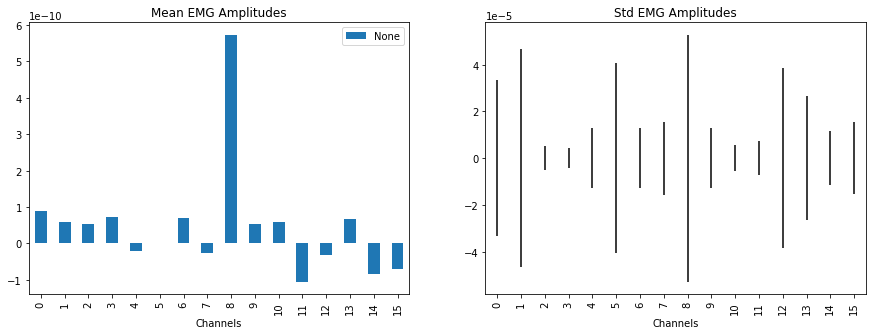

In [21]:
ch_mean = df.mean()
ch_std = df.std()


fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(ncols=2, nrows=1)
ax = fig.add_subplot(gs[0])

df.mean().plot(kind='bar', legend=True, ax= ax, title="Mean EMG Amplitudes")
plt.xlabel('Channels')

ax = fig.add_subplot(gs[1])
ch_mean.plot(yerr=ch_std, kind='bar', title='Std EMG Amplitudes')
plt.xlabel('Channels');

# ch_mean.plot(kind = "barh", y = "mean", legend = False,
#         title = "Average Prices", xerr = "std")

There is a high variance across the channels but also for a single channel between the different gestures

### Gestures Duration

Duration of each gesture
restimulus
0      9.9470
1    113.4495
2    116.2240
3    128.2265
4    117.7705
5    117.6720
6    116.7165
7    153.3750
8    132.7995
9    135.1430
Name: time, dtype: float64


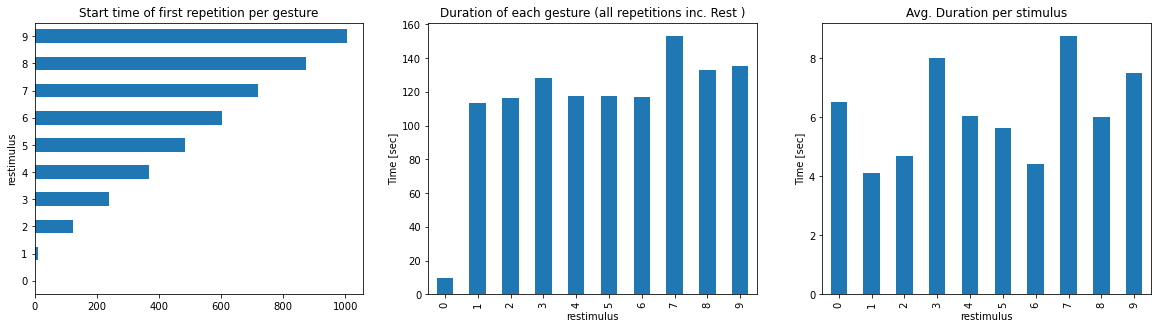

In [80]:
# The first time a new gesture is introduced: i.e time for all trials per gesture
# Adjust the last restimulus duration
gesture_first_time = emg_df.groupby('restimulus').first()['time'] 
gestures_duration = gesture_first_time.diff().shift(-1)
gestures_duration[9] = emg_df.groupby('restimulus').last()['time'][9] - emg_df.groupby('restimulus').first()['time'][9]

fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(nrows=1, ncols=3)
ax = fig.add_subplot(gs[0])
gesture_first_time.plot(kind='barh', title="Start time of first repetition per gesture", ax= ax)


ax = fig.add_subplot(gs[1])
gestures_duration.plot(kind='bar', title="Duration of each gesture (all repetitions inc. Rest )", ax= ax,
                      ylabel='Time [sec]', xlabel='restimulus')


print(f'Duration of each gesture\n{gestures_duration}')

ax = fig.add_subplot(gs[2])
exact_stim_duration = emg_df.groupby(['restimulus','trial'])['time'].last() - emg_df.groupby(['restimulus','trial'])['time'].first()
exact_stim_duration.groupby('restimulus').mean().plot.bar(title='Avg. Duration per stimulus', ylabel='Time [sec]');

**Interpretation**
- Rest (0) is the first movement, it takes 9.947 seconds then all repetitions of gesture 1 are performed which take 113.44 seconds and so on.
- **Note** that Rest trials are interleaved between the gestures, so the duration of rest here is that of the first repetition only. Also the reported duration for gestures is that of all repetitions including the rest trials in between the repetitions.

<AxesSubplot:xlabel='restimulus'>

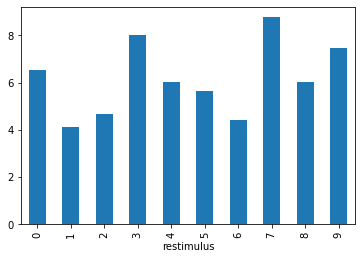

### Mean EMG per gesture

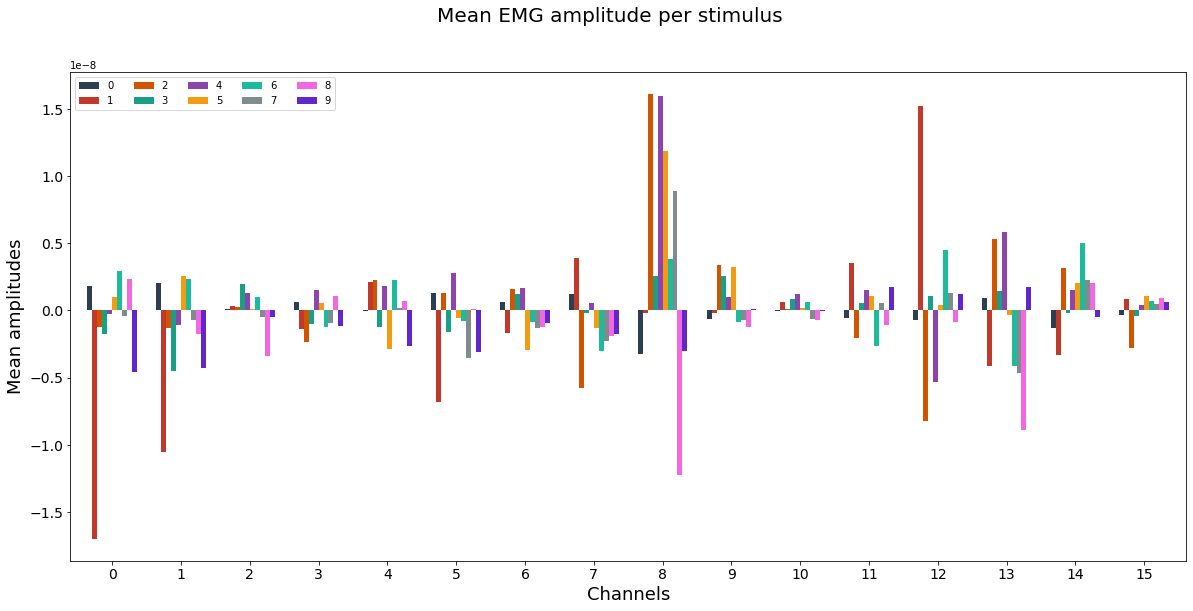

In [52]:
fig = plt.figure(figsize=(20,9))
ax  = fig.add_subplot()
emg_df.groupby('restimulus')[np.arange(N_CH)].mean().T.plot.bar(ax=ax, ylabel='Mean amplitudes',
                                                               xlabel='Channels',
                                                               color=list(COLOR_DICT.values()),
                                                               linewidth=1,
                                                               width=0.72, rot = 0)

ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel(ylabel='Mean amplitudes',fontsize=18)
ax.set_xlabel(xlabel='Channels',fontsize=18)
ax.legend(ncol=5)
fig.suptitle('Mean EMG amplitude per stimulus', fontsize=20);


<AxesSubplot:>

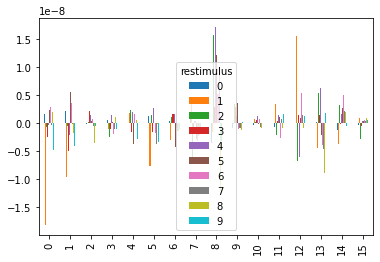

In [55]:
# emg_df.groupby('trial').count()
# mean ampltitude per stimulus
# test = (emg_df.groupby(['restimulus','trial']).mean()).groupby('restimulus')[np.arange(N_CH)].mean()
# test.T.plot.bar()

In [ ]:
emg_df.groupby('restimulus').mean()

In [ ]:
emg_df.groupby('restimulus').mean().T

- Channels are selective of the stimulus. For example channel 8 captures more stimuli 2,4,5,8 and 7.


In [ ]:
# How correlated are the channels
# k = 12 #number of variables for heatmap
# cols = df.corr()
# cm = df.corr()
# plt.figure(figsize=(15,9))
# sns.heatmap(cm, annot=True, cmap = 'viridis')

In [ ]:
# correlation per stimulus
emg_gb_stim = emg_df.groupby('restimulus')[np.arange(N_CH)].mean()
cm = emg_gb_stim.corr()
plt.figure(figsize=(18,9))
sns.heatmap(cm, annot=True, cmap = 'viridis')
plt.title("Channel-wise correlations using mean amplitudes (across all stimuli)", fontsize=15);
plt.xlabel('Channels', fontsize=15)
plt.ylabel('Channels',fontsize=15);

In [ ]:
# correlation between stimulus using mean amplitudes
emg_gb_stim = emg_df.groupby('restimulus')[np.arange(N_CH)].mean().T
stimulus_name = {0: 'rest', 1: 'thumb flex/ext',2: ' thumb ab/ad',
                 3:' index flex/ext' ,
                 4:'mid. flex/ext', 5:'r&l flex/ext',
                 6:'index pointer', 7:'cyl. grip', 8:'lateral grip', 9:'tripod grip'}
cm = emg_gb_stim.corr()
plt.figure(figsize=(18,9))
sns.heatmap(cm, annot=True,xticklabels=stimulus_name.values(), yticklabels=stimulus_name.values())
# plt.title("Correlation between the channels mean amplitudes (across all stimuli)", fontsize=15);
plt.xlabel('Stimulus', fontsize=15)
plt.ylabel('Stimulus',fontsize=15);

In [ ]:
cm.sort_values(by=[7])

In [ ]:
emg_df[(emg_df['restimulus']==0) &]

In [ ]:
# quick test
# for i in range(1): #loop over stimulus
stim_pair = [9,1]
stim_0_test = emg_df[emg_df['restimulus']==stim_pair[0]][np.arange(N_CH)].mean(axis=0)
stim_1_test = emg_df[emg_df['restimulus']==stim_pair[1]][np.arange(N_CH)].mean(axis=0)


np.corrcoef(stim_0_test, stim_1_test)

To compute the stimulus-wise correlation:
- Get the mean of the channels for each stimulus then compute the correlation between the stimuli.

**Observe the following**
1. High correlation between tripod grip and both thumb flexion/extension and index flex/ext. This makes sense since the same fingers are flexed to perform this grip.
2. Surprisingly, rest is also correlated with the grasps.


In [ ]:
# From a single channel
ch = 0
plt.figure(figsize=(15,9))
plt.plot(rec_time, emg_df[ch],color=COLOR_DICT['midnight_blue'], label=f'Ch{ch}')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('amplitude')

In [ ]:
# emg_df.groupby('restimulus').count()

In [ ]:
plt.figure(figsize=(15,9))
# customPalette  = sns.set_palette(sns.color_palette(list(COLOR_DICT.values())))

sns.lineplot(data=emg_df, x="time", y=0, hue="restimulus", 
             palette=sns.color_palette(list(COLOR_DICT.values())))

In [ ]:
# Zooming in
ch = 0
subset_N  = 300000
plt.figure(figsize=(15,9))
sns.lineplot(data=emg_df.loc[:subset_N], x="time", y=ch, hue="restimulus", 
             palette=sns.color_palette(list(COLOR_DICT.values()))[:3])
plt.xticks(ticks=np.arange(0,150,5));
plt.grid(True)
plt.title(f"Channel {ch}")

In [ ]:

# single finger
emg_df['rerepetition'] =  mat['rerepetition']
single_df = emg_df[(emg_df['restimulus']==1) & (emg_df['rerepetition'] == 1)]
ch = 0
subset_N  = 300000
plt.figure(figsize=(15,9))
sns.lineplot(data=single_df, x="time", y=ch, hue="restimulus", 
             palette=sns.color_palette(list(COLOR_DICT.values()))[:1])
# plt.xticks(ticks=np.arange(0,150,5));
plt.grid(True)
plt.title(f"Channel {ch}")



# Glove data

In [ ]:
glove_df['rerepetition'].unique()

In [ ]:
glove_df = pd.DataFrame(mat['glove'])
glove_df['time'] = rec_time
glove_df['restimulus']= mat['restimulus']
glove_df['rerepetition']= mat['rerepetition']
glove_df['count'] = emg_df['count']

glove_df[glove_df['rerepetition']==2]['restimulus'].unique()

In [ ]:
glove_df.groupby('restimulus')['rerepetition'].first()

## Index Finger Marker

In [ ]:

# single finger
# single_df = glove_df[(glove_df['restimulus']==1) & (glove_df['rerepetition'] == 5)] 
single_finger_trial = glove_df[(glove_df['restimulus']==1) & (glove_df['count'] == 2)]  # manually picking the trial nuumber that would correspond to flex/extend finger


print("s")
ch = 5  # channel 6 is on the index finger joint
subset_N  = 300000
plt.figure(figsize=(15,9))
sns.lineplot(data=single_finger_trial, x="time", y=ch, hue="restimulus", 
             palette=sns.color_palette(list(COLOR_DICT.values()))[:1])
plt.grid(True)
plt.title(f"Glove data - Channel# {ch}", fontsize=16)
plt.xlabel('time [sec]')
# plt.xticks()


In [ ]:
glove_df[glove_df['restimulus']==1]['rerepetition'].unique

In [ ]:
fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(nrows=2, ncols=5)

for i, repetition in enumerate(range(1,10)):
    ax = fig.add_subplot(gs[i])

    single_finger_trial = glove_df[(glove_df['restimulus']==1) & (glove_df['count'] == 2)]  # manually picking the trial nuumber that would correspond to flex/extend finger
    gesture_first_time.plot(kind='barh', title="Start time of first repetition per gesture", ax= ax)
    plt.xlabel('Time [sec]')



### Is the date preprocessed already?

*Note: to check if the data is already pre-processed, I can check on the Fourier Transform of the signal and see if the signal is attenuated at frequencies multiple of 50 Hz (power-line interferance)*



#### Conventional preprocessing
1. Notch filters for the power line interference
2. Band pass filters

Also from Hyser Paper, a typical pre-processing pipleine looks like:

> "The acquired HD-sEMG signals were first filtered with 10 Hz highpass and 500 Hz lowpass Butterworth filters (both are zero-phase digital filters processing the signals in both the forward and reverse directions, 8-order each direction). A notch filter combination was then used to attenuate the power line interference at 50 Hz and all harmonic components up to 400 Hz. Force data were filtered with a 10 Hz lowpass Butterworth filter (zero-phase digital filter processing the signals in both the forward and reverse directions, 8-order each direction)."




In [ ]:
# Plot FFT
fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(3, 1)
N = emg_df.shape[0]

ax = fig.add_subplot(gs[0])
yf = fft( np.array(emg_df[0]))
xf = fftfreq(N, 1 / FS)
ax.plot(xf, np.abs(yf))
plt.xlabel('freq[Hz]')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim([-200,200])
plt.show()

In [ ]:
# test
# sampling rate
FS = 300
# sampling interval
ts = 1.0/FS
t = np.arange(0,1,ts)

freq = 100
x = np.sin(2*np.pi*freq*t)
N = x.shape[0]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(gs[0])
yf = fft( x)
xf = fftfreq(N, 1 / FS)

ax.stem(xf, np.abs(yf))
plt.xlabel('freq[Hz]')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim([-200,200])
plt.show()

- note that there is already a notch filter (I think) applied to the signal. Frequencies at multiples of 50 Hz are already attenuated.

In [ ]:
# emg_df['count'] = (emg_df['restimulus'] != emg_df['restimulus'].shift()).cumsum()
# emg_df.iloc[10000:12000]

In [ ]:
# repetition_dur = emg_df.groupby('count')['restimulus'].count()
# repetition_dur/FS

In [ ]:
def create_notch_filters(pipeline, samp_freq):
    w0 = pipeline['notch_reject']
    Q = pipeline['notch_reject'] / pipeline['notch_bandwidth']
    fs = samp_freq
    coeff_tuples = [(signal.iirnotch(w0 * i, Q, fs)) for i in range(1, 11)]
    return coeff_tuples


def create_bp_filter(prepipeline, samp_freq):
    bp_order, bp_cutoff_freq = prepipeline['bp_order'], prepipeline['bp_cutoff_freq']
    b_bp, a_bp = signal.butter(bp_order, bp_cutoff_freq / (samp_freq / 2), btype='bandpass')
    return b_bp, a_bp

def filter_data(data, b_coeff, a_coeff):
    return signal.filtfilt(b_coeff, a_coeff, data)

In [ ]:
pipeline = {'notch_reject': 50, 'notch_bandwidth': 0.5,
           'bp_order':2 , 'bp_cutoff_freq':np.array([2, 500]) }
N_CHANNELS = mat['emg'].shape[1]


In [ ]:
logging.getLogger().setLevel(level=logging.DEBUG)

In [ ]:
notch_filters = create_notch_filters(pipeline, FS)
b_bp, a_bp = create_bp_filter(pipeline, FS)

emg_filter_notch_df = pd.DataFrame()
emg_filter_bp_df = pd.DataFrame()


for ch in tqdm(range(1), desc='Filtered'):
    # stage 1: notch filters
    
    for (b_notch, a_notch) in notch_filters:
        emg_filter_notch_df[ch] = filter_data(emg_df[ch], b_notch, a_notch)
#     logging.debug("After notch: {}".format(temp.shape))

    # stage 2: band pass signal 
    emg_filter_bp_df[ch] = filter_data(emg_filter_notch_df[ch], b_bp, a_bp)
#     logging.debug("After BP: {}".format(temp_2.shape))

In [ ]:
# attach the restimulus column again
emg_filter_notch_df['restimulus'] = emg_df['restimulus']
emg_filter_bp_df['restimulus'] = emg_df['restimulus']

emg_filter_notch_df['time'] = emg_df['time']
emg_filter_bp_df['time'] = emg_df['time']

In [ ]:
# ch = 0
# subset = 2000
# color_pale = 1
# plt.figure(figsize=(15,9))
# sns.lineplot(data=emg_df.loc[:subset], x="time", y=ch, hue="restimulus", 
#              palette=sns.color_palette(list(COLOR_DICT.values()))[:color_pale])
# # plt.xticks(ticks=np.arange(0,150,5));
# plt.grid(True)
# plt.title(f"Channel {ch}")

# plt.figure(figsize=(15,9))
# sns.lineplot(data=emg_filter_notch_df.loc[:subset], x="time", y=ch, hue="restimulus", 
#              palette=sns.color_palette(list(COLOR_DICT.values()))[:color_pale])
# # plt.xticks(ticks=np.arange(0,150,5));
# plt.grid(True)
# plt.title(f"Notch Filter Channel {ch}")


# plt.figure(figsize=(15,9))
# sns.lineplot(data=emg_filter_bp_df.loc[:subset], x="time", y=ch, hue="restimulus", 
#              palette=sns.color_palette(list(COLOR_DICT.values()))[:color_pale])
# # plt.xticks(ticks=np.arange(0,150,5));
# plt.grid(True)
# plt.title(f"Bandpass Filter Channel {ch}")

In [ ]:
# plt.plot(np.abs(fft(emg_df[0])))
# Number of samples in normalized_tone

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15,15))

gs = gridspec.GridSpec(3, 1)

N = emg_df.shape[0]

ax = fig.add_subplot(gs[0])
yf = fft( np.array(emg_df[0]))
xf = fftfreq(N, 1 / FS)
ax.plot(xf, np.abs(yf))
plt.xlim([-200,200])
# plt.show()

ax = fig.add_subplot(gs[1])
yf = fft(np.array(emg_filter_notch_df[0]))
xf = fftfreq(N, 1 / FS)
ax.plot(xf, np.abs(yf))
plt.xlim([-600,500])




ax = fig.add_subplot(gs[2])
yf = fft(np.array(emg_filter_bp_df[0]))
xf = fftfreq(N, 1 / FS)
ax.plot(xf, np.abs(yf))
plt.xlim([-600,500])



## 